In [1]:
%matplotlib inline

import os
#from helper_functions import *

db_file = os.path.abspath("db.json")

In [2]:
from pymatgen import Structure

struct_si = Structure([[5.468344455957462, 0.0, -0.0], 
                       [-0.0, 5.468344455957462, 0.0], 
                       [0.0, -0.0, 5.468344455957462]], 
                      
                      ["Si"]*8, 
                      
                      [[-0.0, -0.0, 0.5],
                       [0.75, 0.75, 0.75],
                       [0.0, 0.5, -0.0],
                       [0.75, 0.25, 0.25],
                       [0.5, 0.0, -0.0],
                       [0.25, 0.75, 0.25],
                       [0.5, 0.5, 0.5],
                       [0.25, 0.25, 0.75]])

In [3]:
from pymatgen.io.vasp.sets import MPRelaxSet, DictSet

vis = MPRelaxSet(struct_si, force_gamma=True)
vis.config_dict["KPOINTS"].update({"reciprocal_density": 600})
vis = DictSet(struct_si, vis.config_dict)

In [4]:
from atomate.vasp.workflows import wf_structure_optimization

c = {"DB_FILE": db_file}
wf = wf_structure_optimization(struct_si, c)

In [5]:
from atomate.vasp.workflows import get_wf_elastic_constant

wf_elastic = get_wf_elastic_constant(struct_si, db_file=db_file, 
                              stencils=[[0.01], [0.01], [0.01], [0.03], [0.03], [0.03]], 
                              copy_vasp_outputs=True)

In [6]:
wf.append_wf(wf_elastic, wf.leaf_fw_ids)

{-8, -7, -6, -5, -4, -3, -2}

In [7]:
from atomate.vasp.powerups import add_modify_incar


wf = add_modify_incar(wf, {'incar_update': {'EDIFF': 1e-6, 'ENCUT': 700}})

In [8]:
# adjust the ref_dir path
from atomate.vasp.powerups import use_fake_vasp

reference_dir = os.path.expanduser("~/workshop_ref_files/elastic_tensor")

si_ref_dirs = {
    "structure optimization": os.path.join(reference_dir, "1"),
    "elastic deformation 0": os.path.join(reference_dir, "7"),
    "elastic deformation 1": os.path.join(reference_dir, "6"),
    "elastic deformation 2": os.path.join(reference_dir, "5"),
    "elastic deformation 3": os.path.join(reference_dir, "4"),
    "elastic deformation 4": os.path.join(reference_dir, "3"),
    "elastic deformation 5": os.path.join(reference_dir, "2")
}

wf = use_fake_vasp(wf, si_ref_dirs, params_to_check=["ENCUT"])

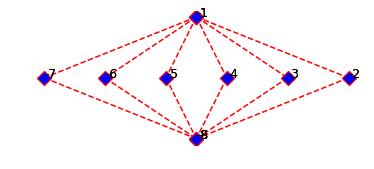

In [9]:
from fireworks.utilities.fw_utilities import plot_wf

plot_wf(wf, depth_factor=2, numerical_label=True)

In [10]:
from fireworks import LaunchPad

lp = LaunchPad()
lp.reset("", require_password=False)

2017-08-01 10:58:18,163 INFO Performing db tune-up
2017-08-01 10:58:18,177 INFO LaunchPad was RESET.


In [11]:
lp.add_wf(wf)

2017-08-01 10:58:18,570 INFO Added a workflow. id_map: {-1: 8, -8: 1, -7: 2, -6: 3, -5: 4, -4: 5, -3: 6, -2: 7}


{-8: 1, -7: 2, -6: 3, -5: 4, -4: 5, -3: 6, -2: 7, -1: 8}

In [12]:
from fireworks import FWorker
from fireworks.core.rocket_launcher import rapidfire

rapidfire(lp)

2017-08-01 10:58:18,660 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-18-660461
2017-08-01 10:58:18,661 INFO Launching Rocket
2017-08-01 10:58:18,688 INFO RUNNING fw_id: 8 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-18-660461
2017-08-01 10:58:18,696 INFO Task started: FileWriteTask.
2017-08-01 10:58:18,701 INFO Task completed: FileWriteTask 
2017-08-01 10:58:18,701 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2017-08-01 10:58:18,714 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2017-08-01 10:58:18,715 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:58:18,718 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}} 
2017-08-01 10:58:18,719 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2017-08-01 10:58:18,750 INFO atomate.vasp.firetasks.run_calc RunVaspF

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-19-111981
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:19,868 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:19,918 INFO Rocket finished
2017-08-01 10:58:19,932 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-19-930183
2017-08-01 10:58:19,937 INFO Launching Rocket
2017-08-01 10:58:19,989 INFO RUNNING fw_id: 6 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-19-930183
2017-08-01 10:58:19,999 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2017-08-01 10:58:20,223 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2017-08-01 10:58:20,223 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2017-08-01 10:58:20,240 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2017-08-01 10:58:20,241 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:5

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-19-930183
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:20,666 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:20,707 INFO Rocket finished
2017-08-01 10:58:20,716 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-20-716237
2017-08-01 10:58:20,718 INFO Launching Rocket
2017-08-01 10:58:20,763 INFO RUNNING fw_id: 5 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-20-716237
2017-08-01 10:58:20,775 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2017-08-01 10:58:21,046 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2017-08-01 10:58:21,047 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2017-08-01 10:58:21,071 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2017-08-01 10:58:21,072 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:5

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-20-716237
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:21,545 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:21,591 INFO Rocket finished
2017-08-01 10:58:21,610 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-21-609457
2017-08-01 10:58:21,614 INFO Launching Rocket
2017-08-01 10:58:21,664 INFO RUNNING fw_id: 4 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-21-609457
2017-08-01 10:58:21,676 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2017-08-01 10:58:21,916 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2017-08-01 10:58:21,917 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2017-08-01 10:58:21,938 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2017-08-01 10:58:21,940 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:5

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-21-609457
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:22,603 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:22,672 INFO Rocket finished
2017-08-01 10:58:22,685 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-22-685547
2017-08-01 10:58:22,688 INFO Launching Rocket
2017-08-01 10:58:22,728 INFO RUNNING fw_id: 3 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-22-685547
2017-08-01 10:58:22,735 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2017-08-01 10:58:22,951 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2017-08-01 10:58:22,952 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2017-08-01 10:58:22,970 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2017-08-01 10:58:22,975 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:5

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-22-685547
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:23,586 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:23,636 INFO Rocket finished
2017-08-01 10:58:23,647 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-23-647166
2017-08-01 10:58:23,650 INFO Launching Rocket
2017-08-01 10:58:23,697 INFO RUNNING fw_id: 2 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-23-647166
2017-08-01 10:58:23,704 INFO Task started: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}}.
2017-08-01 10:58:23,927 INFO Task completed: {{atomate.vasp.firetasks.glue_tasks.CopyVaspOutputs}} 
2017-08-01 10:58:23,928 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2017-08-01 10:58:23,944 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2017-08-01 10:58:23,945 INFO Task started: {{atomate.vasp.firetasks.write_inputs.ModifyIncar}}.
2017-08-01 10:5

/home/km/Software/matproj/pymatgen/pymatgen/io/vasp/outputs.py:822: UserWarning: No POTCAR file with matching TITEL fields was found in /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-23-647166
  " was found in {}".format(os.path.abspath(p)))


2017-08-01 10:58:24,540 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassResult}} 
2017-08-01 10:58:24,585 INFO Rocket finished
2017-08-01 10:58:24,594 INFO Created new dir /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-24-594394
2017-08-01 10:58:24,597 INFO Launching Rocket
2017-08-01 10:58:24,634 INFO RUNNING fw_id: 1 in directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-24-594394
2017-08-01 10:58:24,644 INFO Task started: {{atomate.vasp.firetasks.parse_outputs.ElasticTensorToDb}}.
2017-08-01 10:58:24,648 INFO atomate.vasp.firetasks.parse_outputs Parsing initial optimization directory: /home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-18-660461
2017-08-01 10:58:24,649 INFO atomate.vasp.drones Getting task doc for base dir :/home/km/Software/matproj/workshop-2017/Atomate/launcher_2017-08-01-17-58-18-660461
2017-08-01 10:58:24,828 INFO atomate.vasp.drones Post-processing dir:/home/km/Soft

In [13]:
from atomate.vasp.database import VaspCalcDb

vasp_db = VaspCalcDb.from_db_file(db_file)

In [14]:
def get_task_id(name):
    fw = None
    for i in lp.get_fw_ids():
        fw=lp.get_fw_by_id(i)
        if fw.name == name:
            break
    return fw.launches[-1].action.stored_data["task_id"]

In [15]:
task_id = get_task_id("elastic deformation 4")
d = vasp_db.collection.find_one({"task_label":"elastic deformation 4"})

In [16]:
d["calcs_reversed"][0]["output"]["ionic_steps"][-1]["stress"]

[[3.25702976, 0.0, -45.03552717],
 [0.0, -0.60369959, 0.0],
 [-45.03552718, 0.0, 1.66978914]]

In [17]:
d = vasp_db.db.elasticity.find_one()

In [18]:
d["order"]

2

In [19]:
d['elastic_tensor']['ieee_format']

[[146.25385837056845,
  52.26244897838195,
  52.262448978381975,
  -5.782411586589357e-19,
  -4.625929269271485e-18,
  -4.625929269271485e-18],
 [52.26244897838195,
  146.25385837056848,
  52.26244897838197,
  -4.625929269271485e-18,
  -5.782411586589357e-19,
  -9.25185853854297e-18],
 [52.262448978381975,
  52.26244897838197,
  146.25385837056845,
  -9.25185853854297e-18,
  -6.938893903907228e-18,
  -5.782411586589357e-19],
 [-5.782411586589357e-19,
  -4.625929269271485e-18,
  -9.25185853854297e-18,
  75.22653076702798,
  0.0,
  0.0],
 [-4.625929269271485e-18,
  -5.782411586589357e-19,
  -6.938893903907228e-18,
  0.0,
  75.22653076702797,
  0.0],
 [-4.625929269271485e-18,
  -9.25185853854297e-18,
  -5.782411586589357e-19,
  0.0,
  0.0,
  75.226530767028]]